<a href="https://colab.research.google.com/github/Narakuz/streamlit-example/blob/master/gedi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import ee
import geemap
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import os
from pathlib import Path
from tqdm import tqdm
from shapely.geometry import Polygon
from scipy import stats
from shapely.geometry import Polygon, MultiPolygon
from geemap import cartoee
from glob import glob
from sklearn import metrics
ee.Authenticate()
ee.Initialize(project='ee-xizhurs')

In [18]:
def clipcol(image, roi):
    clipimage = image.clip(roi)
    return clipimage

def qualityMaskb(img):
    return img.updateMask(img.select('l2b_quality_flag').eq(1)) \
              .updateMask(img.select('degrade_flag').eq(0)) \
              .updateMask(img.select('sensitivity').gte(0.9)) \
              .updateMask(img.select('solar_elevation').lt(0)) \
              .updateMask(img.select('pai').gte(0))

def qualityMaska(img):
    return img.updateMask(img.select('quality_flag').eq(1)) \
              .updateMask(img.select('degrade_flag').eq(0)) \
              .updateMask(img.select('sensitivity').gte(0.9)) \
              .updateMask(img.select('solar_elevation').lt(0)) \
              .updateMask(img.select('rh98').gte(0))

def retainBand_pai(img):
    return img.select(
    img.bandNames().filter(
      ee.Filter.stringStartsWith('item', 'pai')))

def retainBand_h(img):
    return img.select(
    img.bandNames().filter(
      ee.Filter.stringStartsWith('item', 'rh')))

def scaleBands(image):
    return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

def maskLowQA(image):
    qaBand = 'cs'
    clearThreshold = 0.5
    mask = image.select(qaBand).gte(clearThreshold)
    return image.updateMask(mask)

def addIndices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
    mndwi = image.normalizedDifference(['B3', 'B11']).rename('mndwi')
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('ndbi')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {'NIR': image.select('B8'), 'RED': image.select('B4'), 'BLUE': image.select('B2')}
    ).rename('evi')
    bsi = image.expression(
        '((X + Y) - (A + B)) / ((X + Y) + (A + B))',
        {'X': image.select('B11'), 'Y': image.select('B4'), 'A': image.select('B8'), 'B': image.select('B2')}
    ).rename('bsi')
    return image.addBands([ndvi, mndwi, ndbi, evi, bsi])

def calculate_rmse(input):
    observed = ee.Array(input.aggregate_array('pai'))
    predicted = ee.Array(input.aggregate_array('pai_predicted'))
    rmse = observed.subtract(predicted).pow(2) \
        .reduce('mean', [0]).sqrt().get([0])
    return rmse

In [46]:
# dir_aoi = "/content/drive/MyDrive/Work Nicaragua/gedi/Nicaragua_lidar_area.geojson"
dir_aoi = "/content/drive/MyDrive/Work Colombia/gedi/Colombia_lidar_bounds_2023.geojson"
startDate = "2021-01-01"
endDate = "2021-08-01"
gdf = gpd.read_file(dir_aoi)
gdf_aoi = gdf.to_crs(32736).buffer(300000).to_crs(4326)

roi_original = ee.Geometry.BBox(*gdf.total_bounds)
roi = ee.Geometry.BBox(*gdf_aoi.total_bounds)

# roi1 = ee.Geometry.BBox(*gpd.read_file(dir_aoi).iloc[0:1].total_bounds)
# roi2 = ee.Geometry.BBox(*gpd.read_file(dir_aoi).iloc[1:2].total_bounds)
# roi3 = ee.Geometry.BBox(*gpd.read_file(dir_aoi).iloc[2:3].total_bounds)
# 32616 Nicaragua
# 32736 Tanzania

In [47]:
gedi_b = (
    ee.ImageCollection('LARSE/GEDI/GEDI02_B_002_MONTHLY')
    .filterDate(startDate, endDate)
    .filterBounds(roi)
    .map(qualityMaskb)
    # .map(retainBand_pai)
    .map(lambda x: clipcol(x, roi))
)
gediProjection = ee.Image(gedi_b.first()).select('pai').projection()
gediMosaic_b = gedi_b.mosaic().select('pai').setDefaultProjection(gediProjection)
gediMosaic_c = gedi_b.mosaic().select('fhd_normal').setDefaultProjection(gediProjection)
gediMosaic_d = gedi_b.mosaic().select('cover').setDefaultProjection(gediProjection)

gedi_a = (
    ee.ImageCollection('LARSE/GEDI/GEDI02_A_002_MONTHLY')
    .filterDate(startDate, endDate)
    .filterBounds(roi)
    .map(qualityMaska)
    .map(retainBand_h)
    .map(lambda x: clipcol(x, roi))
)
gediProjection = ee.Image(gedi_a.first()).select('rh95').projection()
gediMosaic_a = gedi_a.mosaic().select('rh95').setDefaultProjection(gediProjection)

# gediMosaic = gediMosaic_a.addBands(gediMosaic_b).addBands(gediMosaic_c).addBands(gediMosaic_d)
gediMosaic = gediMosaic_d.addBands(gediMosaic_c).addBands(gediMosaic_a).addBands(gediMosaic_b)
gediMosaic = gediMosaic.updateMask(gediMosaic.select('cover').gte(0)) \
.updateMask(gediMosaic.select('rh95').gte(0)) \
.updateMask(gediMosaic.select('fhd_normal').gte(0)) \
.updateMask(gediMosaic.select('pai').gte(0))
Map = geemap.Map(basemap='Esri.WorldImagery', zoom=3, center=(-10, -55))
vis_params_b = {
    "bands": ["pai"],
    "min": 0,
    "max": 9,
    'palette': ['00FFFF', '0000FF']
}
# vis_params_a = {
#     "bands": ["cover"],
#     "min": 0,
#     "max": 1,
# }
Map.addLayer(gediMosaic, vis_params_b)
# Map.addLayer(gediMosaic, vis_params_a)

Map.addLayer(roi_original)
Map.addLayer(roi)
# Map.addLayer(roi2)
# Map.addLayer(roi3)
Map.centerObject(roi)
Map

Map(center=[-10, -55], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [48]:
gediMosaic.select("cover").reduceRegion(reducer=ee.Reducer.count(), geometry=roi, scale=25, maxPixels=1e9)

In [ ]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
filteredS2 = s2.filter(ee.Filter.date(startDate, endDate)).filterBounds(roi).map(lambda x: clipcol(x, roi))
s2Projection = ee.Image(filteredS2.first()).select('B4').projection()
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
csPlusBands = csPlus.first().bandNames()

filteredS2WithCs = filteredS2.linkCollection(csPlus, csPlusBands)
s2Processed = filteredS2WithCs.map(maskLowQA).select(['B.*']).map(scaleBands).map(addIndices)
# Create the Sentinel-2 composite
s2Composite = s2Processed.median().setDefaultProjection(s2Projection)

Map = geemap.Map(zoom=3, center=(-10, -55))
vis_params = {
    "bands": ["ndvi"],
    "min": 0,
    "max": 1,
}
Map.addLayer(s2Composite, vis_params)
vis_params = {
    "bands": ["pai"],
    "min": 0,
    "max": 3,
}
Map.addLayer(gediMosaic, vis_params)
Map.centerObject(roi)
Map

Map(center=[-10, -55], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [ ]:
glo30 = ee.ImageCollection('NOAA/NGDC/ETOPO1')
glo30Filtered = glo30.filterBounds(roi).select(['DEM'])
demProj = glo30Filtered.first().select([0]).projection()
elevation = glo30Filtered.mosaic().rename(['dem']).setDefaultProjection(demProj)
slope = ee.Terrain.slope(elevation)
demBands = elevation.addBands(slope)

In [49]:
exportPath = "projects/ee-xizhurs/assets/gedi/"
# s2Export = s2Composite.clip(roi)
# s2Task = ee.batch.Export.image.toAsset(
#     image=s2Export,
#     description='s2Composite_Export',
#     assetId=exportPath + 's2Composite',
#     region=roi,
#     scale=10,
#     maxPixels=1e10
# )
# s2Task.start()

gediMosaicExport = gediMosaic.clip(roi)
# gediMosaicTask = ee.batch.Export.image.toAsset(
#     image=gediMosaicExport,
#     description='GEDI_Mosaic_Export',
#     assetId=exportPath + 'gedi_mosaic_Nicaragua',
#     region=roi,
#     scale=25,
#     maxPixels=1e10
# )
# gediMosaicTask.start()

task = ee.batch.Export.image.toDrive(
    image=gediMosaicExport,
    description='GEDI_Mosaic_Export_4bands',
    folder='Work Colombia',
    region=roi,
    scale=25,
    maxPixels=1e10
)
task.start()

In [ ]:
# exportPath = "projects/ee-xizhurs/assets/gedi/"
# s2Composite = ee.Image(exportPath + 's2Composite')
# gediMosaic = ee.Image(exportPath + 'gedi_mosaic')

gridScale = 100
gridProjection = ee.Projection(s2Projection).atScale(gridScale)
stacked = s2Composite.addBands(gediMosaic)
stacked = stacked.resample('bilinear')
stackedResampled = stacked.reduceResolution(
    reducer=ee.Reducer.mean(),
    maxPixels=1024
).reproject(
    crs=gridProjection
)

stackedResampled = stackedResampled.updateMask(stackedResampled.mask().gt(0))

Map = geemap.Map(zoom=3, center=(-10, -55))
vis_params = {
    "bands": ["ndvi"],
    "min": 0,
    "max": 1,
}
Map.addLayer(stackedResampled, vis_params)

vis_params = {
    "bands": ["pai"],
    "min": 0,
    "max": 3,
}
Map.addLayer(stackedResampled, vis_params)

Map.centerObject(roi)
Map

Map(center=[-10, -55], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [ ]:
predictors = s2Composite.bandNames()
predicted = gediMosaic.bandNames().get(0)
predictorImage = stackedResampled.select(predictors)
predictedImage = stackedResampled.select([predicted])

classMask = predictedImage.mask().toInt().rename('class')
numSamples = 10000

training = stackedResampled.addBands(classMask).stratifiedSample(
    numPoints=numSamples,
    classBand='class',
    region=roi,
    scale=gridScale,
    classValues=[0, 1],
    classPoints=[0, numSamples],
    dropNulls=True,
    tileScale=16
)
# print('Number of Features Extracted', training.size()) ;
# print('Sample Training Feature', training.first())

In [ ]:
model = ee.Classifier.smileRandomForest(100) \
    .setOutputMode('REGRESSION') \
    .train(
        features=training,
        classProperty='pai',
        inputProperties=predictors  # Replace with actual predictor band names
    )

predicted = training.classify(
    classifier=model,
    outputName='pai_predicted'
)

rmse = calculate_rmse(predicted)
print('RMSE:', rmse.getInfo())

RMSE: 0.3412341639198094


0.6034842331060464


<Axes: xlabel='pai', ylabel='pai_predicted'>

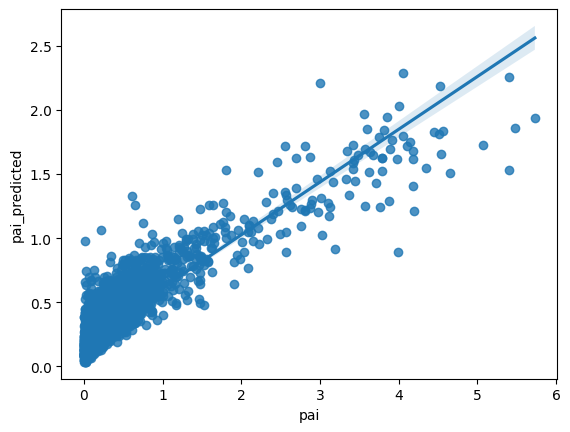

In [ ]:
nested_list = predicted.reduceColumns(ee.Reducer.toList(len(["pai", "pai_predicted"])), ["pai", "pai_predicted"]).values().get(0)
data = nested_list.getInfo()

df = pd.DataFrame(data, columns=["pai", "pai_predicted"])
print(metrics.r2_score(df["pai"], df["pai_predicted"]))

sns.regplot(data=df, x="pai", y="pai_predicted")